In [242]:
import pandas as pd
import os
from os import path, getcwd, listdir
import re
from re import match
import seaborn as sns

In [243]:
# Path and files of current directory
current_dir = getcwd()
dir_files = listdir()

subway_data = None

# Merging the data from txt files to dataframes
for dir_file in dir_files:
    if match("^turnstile_\d*.*txt$", dir_file, re.IGNORECASE) is not None:
        file_path = path.join(current_dir, dir_file)
        current_data = pd.read_csv(file_path)
        if subway_data is not None:
            subway_data = subway_data.append(current_data)
        else:
            subway_data = current_data

subway_data.head()

C/A  UNIT       SCP STATION LINENAME DIVISION        DATE      TIME  \
0  A002  R051  02-00-00   59 ST  NQR456W      BMT  03/28/2020  00:00:00   
1  A002  R051  02-00-00   59 ST  NQR456W      BMT  03/28/2020  04:00:00   
2  A002  R051  02-00-00   59 ST  NQR456W      BMT  03/28/2020  08:00:00   
3  A002  R051  02-00-00   59 ST  NQR456W      BMT  03/28/2020  12:00:00   
4  A002  R051  02-00-00   59 ST  NQR456W      BMT  03/28/2020  16:00:00   

      DESC  ENTRIES  \
0  REGULAR  7412829   
1  REGULAR  7412831   
2  REGULAR  7412837   
3  REGULAR  7412849   
4  REGULAR  7412880   

   EXITS                                                                 
0                                            2516511                     
1                                            2516512                     
2                                            2516526                     
3                                            2516538                     
4                                            2516555

In [244]:
# Coulmn names ['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME', 'DESC', 'ENTRIES', 'EXITS']  
subway_data.columns = ['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME', 'DESC', 'ENTRIES', 'EXITS']
column_names = list(subway_data.columns)

In [245]:
subway_station_data = subway_data[['STATION', 'DATE', 'TIME', 'ENTRIES', 'EXITS']]

#Combining the date and time
subway_station_data['DATETIME'] = subway_station_data['DATE'] + ' ' + subway_station_data['TIME']
subway_station_data.drop(columns = ['DATE', 'TIME'], inplace = True)
subway_station_data['DATETIME'] = pd.to_datetime(subway_station_data.DATETIME)
subway_station_data = subway_station_data.groupby(['STATION', 'DATETIME']).sum().reset_index()
subway_station_data['DATE'] = subway_station_data['DATETIME'].dt.date

subway_station_data.head()

STATION            DATETIME  ENTRIES    EXITS        DATE
0    1 AV 2020-03-28 00:00:00   781442  1344007  2020-03-28
1    1 AV 2020-03-28 04:00:00   781476  1344057  2020-03-28
2    1 AV 2020-03-28 08:00:00   781518  1344312  2020-03-28
3    1 AV 2020-03-28 12:00:00   781608  1344611  2020-03-28
4    1 AV 2020-03-28 16:00:00   781763  1344908  2020-03-28

In [246]:
# Sorting Data Accoring to Timestamp
subway_station_data.sort_values(by = ['STATION', 'DATETIME'], inplace = True)
subway_station_data.head(5)


STATION            DATETIME  ENTRIES    EXITS        DATE
0    1 AV 2020-03-28 00:00:00   781442  1344007  2020-03-28
1    1 AV 2020-03-28 04:00:00   781476  1344057  2020-03-28
2    1 AV 2020-03-28 08:00:00   781518  1344312  2020-03-28
3    1 AV 2020-03-28 12:00:00   781608  1344611  2020-03-28
4    1 AV 2020-03-28 16:00:00   781763  1344908  2020-03-28

In [247]:
subway_station_data.sort_values(by = ['STATION', 'DATE', 'ENTRIES']).groupby(['STATION']).diff(axis = 0)

DATETIME  ENTRIES  EXITS     DATE
0           NaT      NaN    NaN      NaN
1      04:00:00     34.0   50.0  0:00:00
2      04:00:00     42.0  255.0  0:00:00
3      04:00:00     90.0  299.0  0:00:00
4      04:00:00    155.0  297.0  0:00:00
...         ...      ...    ...      ...
209678 04:00:00      4.0    2.0  0:00:00
209679 04:00:00    195.0  101.0  0:00:00
209680 04:00:00     90.0   75.0  0:00:00
209681 04:00:00     92.0  149.0  0:00:00
209682 04:00:00     61.0  143.0  0:00:00

[209683 rows x 4 columns]

In [248]:
# Calculating difference between entries, exits and times
subway_station_data[['TIME_DIFF', 'ENTRIES_DIFF', 'EXITS_DIFF', 'DATE']] = subway_station_data.sort_values(by = ['STATION', 'DATE', 'ENTRIES']).groupby(['STATION']).diff(axis = 0)
subway_station_data.drop(columns = ['DATE'], inplace = True)
subway_station_data.head()

STATION            DATETIME  ENTRIES    EXITS TIME_DIFF  ENTRIES_DIFF  \
0    1 AV 2020-03-28 00:00:00   781442  1344007       NaT           NaN   
1    1 AV 2020-03-28 04:00:00   781476  1344057  04:00:00          34.0   
2    1 AV 2020-03-28 08:00:00   781518  1344312  04:00:00          42.0   
3    1 AV 2020-03-28 12:00:00   781608  1344611  04:00:00          90.0   
4    1 AV 2020-03-28 16:00:00   781763  1344908  04:00:00         155.0   

   EXITS_DIFF  
0         NaN  
1        50.0  
2       255.0  
3       299.0  
4       297.0

In [249]:
# Calculating Rates
subway_data_rates = subway_station_data.dropna(subset = ['ENTRIES_DIFF', 'EXITS_DIFF', 'TIME_DIFF'])
subway_data_rates['TIME_DIFF(MIN)'] = subway_data_rates.TIME_DIFF.dt.seconds.div(60).astype(int)
subway_data_rates['ENTRY_RATE'] = subway_data_rates['ENTRIES_DIFF'] / subway_data_rates['TIME_DIFF(MIN)']
subway_data_rates['EXIT_RATE'] = subway_data_rates['EXITS_DIFF'] / subway_data_rates['TIME_DIFF(MIN)']
subway_data_rates.head()

STATION            DATETIME  ENTRIES    EXITS TIME_DIFF  ENTRIES_DIFF  \
1    1 AV 2020-03-28 04:00:00   781476  1344057  04:00:00          34.0   
2    1 AV 2020-03-28 08:00:00   781518  1344312  04:00:00          42.0   
3    1 AV 2020-03-28 12:00:00   781608  1344611  04:00:00          90.0   
4    1 AV 2020-03-28 16:00:00   781763  1344908  04:00:00         155.0   
5    1 AV 2020-03-28 20:00:00   781898  1345128  04:00:00         135.0   

   EXITS_DIFF  TIME_DIFF(MIN)  ENTRY_RATE  EXIT_RATE  
1        50.0             240    0.141667   0.208333  
2       255.0             240    0.175000   1.062500  
3       299.0             240    0.375000   1.245833  
4       297.0             240    0.645833   1.237500  
5       220.0             240    0.562500   0.916667

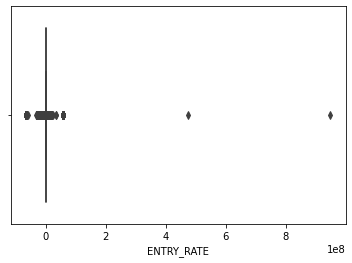

In [250]:

sns.boxplot(x = subway_data_rates.ENTRY_RATE)

In [251]:
subway_data_rates.describe()

ENTRIES         EXITS               TIME_DIFF  ENTRIES_DIFF  \
count  2.093050e+05  2.093050e+05                  209305  2.093050e+05   
mean   2.981444e+08  2.444359e+08  0 days 02:06:53.642273  1.678917e+05   
std    8.186858e+08  7.345251e+08  0 days 06:40:02.666594  2.334224e+08   
min    0.000000e+00  0.000000e+00       -1 days +00:02:22 -7.010448e+09   
25%    9.173200e+04  7.427100e+04         0 days 04:00:00  3.000000e+00   
50%    8.893827e+06  5.461126e+06         0 days 04:00:00  3.900000e+01   
75%    8.609737e+07  3.699485e+07         0 days 04:12:00  1.790000e+02   
max    7.263365e+09  6.095662e+09         1 days 20:00:00  6.993835e+09   

         EXITS_DIFF  TIME_DIFF(MIN)    ENTRY_RATE     EXIT_RATE  
count  2.093050e+05   209305.000000  2.093040e+05  2.093050e+05  
mean   1.780336e+05      249.376374           NaN           NaN  
std    2.269916e+08       73.486474           NaN           NaN  
min   -5.977989e+09        0.000000          -inf          -inf  
25%    4.000000e+00      240.000000  1.190476e-02  1.587302e-02  
50%    3.900000e+01      240.000000  1.625000e-01  1.583333e-01  
75%    1.630000e+02      252.000000  7.458333e-01  6.791667e-01  
max    5.962249e+09     1439.000000           inf           inf

In [257]:
# Removing outliers

subway_data_cleaned = subway_data_rates[subway_data_rates.ENTRIES_DIFF >=0]
subway_data_cleaned = subway_data_cleaned[subway_data_rates.ENTRIES_DIFF < 1e3]
subway_data_cleaned = subway_data_cleaned[subway_data_rates.EXITS_DIFF >=0]
subway_data_cleaned = subway_data_cleaned[subway_data_rates.EXITS_DIFF < 1e3]
subway_data_cleaned = subway_data_cleaned[subway_data_rates['TIME_DIFF(MIN)'] > 0]

subway_data_cleaned.describe()

ENTRIES         EXITS               TIME_DIFF   ENTRIES_DIFF  \
count  1.834980e+05  1.834980e+05                  183498  183498.000000   
mean   2.841152e+08  2.277472e+08  0 days 04:03:24.602567      93.396053   
std    7.719110e+08  6.875194e+08  0 days 00:44:58.995179     146.888195   
min    0.000000e+00  0.000000e+00       -1 days +00:51:40       0.000000   
25%    1.125358e+05  8.656250e+04         0 days 04:00:00       2.000000   
50%    1.203746e+07  7.397042e+06         0 days 04:00:00      30.000000   
75%    8.613617e+07  3.699504e+07         0 days 04:12:00     123.000000   
max    7.263361e+09  6.095656e+09         1 days 16:00:00     999.000000   

          EXITS_DIFF  TIME_DIFF(MIN)     ENTRY_RATE      EXIT_RATE  
count  183498.000000   183498.000000  183498.000000  183498.000000  
mean      100.040104      245.887873       0.389555       0.417342  
std       153.246178       34.193708       0.617891       0.663850  
min         0.000000        1.000000       0.000000       0.000000  
25%         5.000000      240.000000       0.007937       0.019841  
50%        36.000000      240.000000       0.120833       0.146825  
75%       130.000000      252.000000       0.512500       0.541667  
max       999.000000     1370.000000      15.000000      34.000000

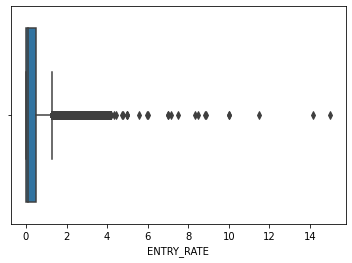

In [258]:
sns.boxplot(x = subway_data_cleaned.ENTRY_RATE)